## Α. Στοιχεία ομάδας

# ΟΜΑΔΑ Β51


##  ΜΙΑΜΗΣ ΧΡΗΣΤΟΣ      03113045
## ΜΑΝΚΑ ΣΥΛΒΙΑ           03113043


### Άσκηση 3: Βελτιστοποίηση συναρτήσεων με Γενετικούς Αλγόριθμους


Οι συναρτήσεις που έχουν ανατεθεί στην ομάδα μας είναι η 120 και η 172.
** Η 120 είχε ένα λάθος στο δοσμένο paper κι επίσης βάσει του ορισμού της είναι scalable αλλά παρακάτω έχει οριστεί διορθωμένη κι επίσης για δυο μεταβητές για τις ανάγκες της εργασίας. **



---



**120 : Schwefel 2.4 Function (Non Scalable) **

$$ f(x_{1},x_{2}) = (x_{1} - 1)^2 + (x_{1} - x_{1}^2)^2 + (x_{2} - 1)^2 + (x_{2} - x_{2}^2)^2 $$

$$0 \leq x_{1}, x_{2} \leq 10 $$

$$ x^{*} = (1,1), f(x^{*}) = 0 $$

**172 : Xin-She Yang Function 4 (Scalable) **

$$f(x_{1}, x_{2}, ... , x_{n}) = \bigg(\sum_{i=1}^{n}\sin^2(x_{i}) - e^{-\sum_{i=1}^{n}x_{i}^2}\bigg)e^{-\sum_{i=1}^{n}\sin^2\sqrt{\mid x_{i} \mid}} $$

$$-10 \leq x_{i} \leq 10 $$

$$ x^{*} = (0,0,...,0), f(x^{*}) = -1 $$




In [0]:
!pip install --upgrade pip
!pip install --upgrade deap
!pip install --upgrade numpy

In [0]:
from deap import base, creator
from deap import tools
import random
import time
from math import *
from deap import algorithms
import numpy as np
import pandas as pd
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Μέρος 1. Βελτιστοποίηση μη κλιμακούμενης συνάρτησης



### Εύρεση βέλτιστου συνδυασμού τελεστών - στρατηγικής

#### Ορισμός Βασικών Συναρτήσεων

Για καλύτερη εποπτεία παραθέτουμε την non scalable συνάρτηση

**120 : Schwefel 2.4 Function (Non Scalable) **

$$ f(x_{1},x_{2}) = (x_{1} - 1)^2 + (x_{1} - x_{1}^2)^2 + (x_{2} - 1)^2 + (x_{2} - x_{2}^2)^2 $$




In [0]:
def evalSchwefelFun(ind): #ind should be a list of two elements because Schwefel function is defined on two variables
  sum = 0;
  for x in ind:
    sum = sum + pow(x-1,2) + pow(x-pow(x,2),2);
  return (sum,)

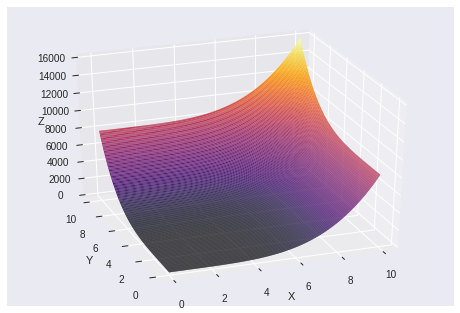

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, -110)
x = y = np.arange(0, 10.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([evalSchwefelFun([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Κάνουμε μερικές δοκιμές

In [0]:
print evalSchwefelFun([2,0])
print evalSchwefelFun([0,2])
print evalSchwefelFun([0,0])
print evalSchwefelFun([10,10])


(6.0,)
(6.0,)
(2.0,)
(16362.0,)


$$ x^{*} = (1,1), f(x^{*}) = 0 $$

In [0]:
print evalSchwefelFun([1,1])

(0.0,)


$$0 \leq x_{1}, x_{2} \leq 10 $$

Βάσει του πεδίου ορισμού της συνάρτησης ορίζουμε την εφικτότητα και την απόσταση που θα χρησιμοποιηθούν για το penalty function.

**Προφανώς δεν μπορούμε να γνωρίζουμε εκ των προτέρων μια σωστή συνάρτηση απόστασης κι ενός Δ (χρησιμοποιείται αργότερα) παρά μόνο αν μελετήσουμε διαισθητικά τη συνάρτησή μας ώστε να την φράξουμε πάνω κάτω και να είμαστε σίγουροι ότι το penalty της fitness function θα είναι μεγαλύτερο από το άνω φράγμα της συνάρτησης (οπωσδήποτε μεγαλύτερο από το κάτω φράγμα). **

Η συνάρτησή μας μπορεί να οριστεί σε όλο το R αλλά αυτό δεν πρέπει να παίξει ρόλο καθώς θα μπορούσαμε να έχουμε μια συνάρτηση που ορίζεται αυστηρώς στο πεδίο ορισμού της. Μελετώντας τη συνάρτησή μας μπορούμε εύκολα να την φράξουμε από πάνω εντός του πεδίου ορισμού της με τριγωνικές ανισότητες, αλλά θα αποφύγουμε όλες αυτές τις διαδικάσίες κι απλά θα χρησιμοποιήσουμε μια νόρμα ως distance που παρουσιάζεται στο documentation και ως Δ αργότερα απλά θα χρησιμοποιήσουμε κάποιον "μεγάλο" αριθμό.

In [0]:
MIN_BOUND = 0
MAX_BOUND = 10

def feasibleSchwefelFun( indiv ):
    return all(x >= MIN_BOUND and x <= MAX_BOUND for x in indiv)

def distanceSchwefelFun( indiv ) :
    dist = 0.0
    for x in indiv :
        penalty = 0
        if ( x < MIN_BOUND) : 
          penalty = 0 - x
        if ( x > MAX_BOUND) : 
          penalty = x - 10
        dist = dist + penalty
    return dist

#### Γενετικοί τελεστές

Αρχικά θα δοκιμάσουμε δύο διαφορετικούς τελεστές διασταύρωσης και δύο διαφορετικούς τελεστές μετάλλαξης με δύο διαφορετικές τιμές υπερ-παραμέτρων για τον καθένα (μία χαμηλή-low και μία υψηλή-high). Θα δοκιμάσουμε επίσης δύο τιμές υπερ-παραμέτρων για τον τελεστή επιλογής selTournament. Έχουμε δηλαδή συνολικά 32 συνδυασμούς τελεστών. Οι επιλογές φαίνονται στην παρακάτω εικόνα:

![alt text](https://i.ibb.co/yQ16Ks5/Selections.png)



---



Όλοι οι συνδυασμοί που προκύπτουν **για μια συγκεκριμένη στρατηγική** φαίνονται στον παρακάτω πίνακα. Οι στρατηγικές μας είναι τρεις eaSimple, M+L και M,L επομένως **θα έχουμε συνολικά 32*3 = 96 συνδυασμούς τελεστών-στρατηγικής για τη βελτιστοποίηση**.


---




| No | Crossover  | Cx Hyperparameter   | Mutation   | Mut Hyperparameter  | selTournament Hyperparameter   |
|------|------|------|------|------|------|
|   01  | cxUniform| Low| mutGaussian| Low| Low|
|   02  | cxUniform| Low| mutGaussian| Low| High|
|   03  | cxUniform| Low| mutGaussian| High| Low|
|   04  | cxUniform| Low| mutGaussian| High| High|
|   05  | cxUniform|High| mutGaussian| Low| Low|
|   06  | cxUniform|High| mutGaussian| Low| High|
|   07  | cxUniform| High| mutGaussian| High| Low|
|   08  | cxUniform|High| mutGaussian| High| High|
|   09  | cxUniform| Low| mutShuffleIndexes| Low| Low|
|   10  | cxUniform| Low| mutShuffleIndexes| Low| High|
|  11  | cxUniform| Low|mutShuffleIndexes| High| Low|
|   12  | cxUniform| Low| mutShuffleIndexes| High| High|
|  13  | cxUniform|High| mutShuffleIndexes| Low| Low|
|   14  | cxUniform|High| mutShuffleIndexes| Low| High|
|   15  | cxUniform| High| mutShuffleIndexes| High| Low|
|   16  | cxUniform|High| mutShuffleIndexes| High| High|
|   17  | cxBlend| Low| mutGaussian| Low| Low|
|   18  |cxBlend| Low| mutGaussian| Low| High|
|   19 | cxBlend| Low| mutGaussian| High| Low|
|  20 | cxBlend| Low| mutGaussian| High| High|
|   21  | cxBlend|High| mutGaussian| Low| Low|
|   22 | cxBlend|High| mutGaussian| Low| High|
|  23  | cxBlend| High| mutGaussian| High| Low|
|   24  | cxBlend|High| mutGaussian| High| High|
|   25  | cxBlend| Low| mutShuffleIndexes| Low| Low|
|   26  | cxBlend| Low| mutShuffleIndexes| Low| High|
|  27  | cxBlend| Low|mutShuffleIndexes| High| Low|
|   28  | cxBlend| Low| mutShuffleIndexes| High| High|
|  29 | cxBlend|High| mutShuffleIndexes| Low| Low|
|   30  | cxBlend|High| mutShuffleIndexes| Low| High|
|   31  | cxBlend| High| mutShuffleIndexes| High| Low|
|   32  | cxBlend|High| mutShuffleIndexes| High| High|

Παρακάτω ορίζουμε μια συνάρτηση η οποία για έναν δοσμένο συνδυασμό (από τους προαναφερθέντες) θα επιστρέφει τα σχετικά κριτήρια που ορίζονται στην εκφώνηση της άσκησης γι' αυτόν τον συνδυασμό και τα οποία εν συνεχεία θα χρησιμοποιηθούν για τις συνολικές μας μετρήσεις.

In [0]:
# Αρχικοποιούμε έναν creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Το αρνητικό πρόσημο σημαίνει την ελαχιστοποίηση της συνάρτησης και το ότι τα weights είναι ένας αριθμός σημαίνει ότι ελαχιστοποιούμε ένα κριτήριο μόνο.
creator.create("Individual", list, fitness=creator.FitnessMin)

In [0]:
def metrics_of_a_combination(fun_obj, select_mate, select_mutate, mate_hyperparameter, mutate_hyperparameter, select_hyperparameter, strategy, POPSIZE, MAX_GENS, CXPB, MUTPB):

  # Explanation of the arguments
  
  
  # fun_obj                  --> Contains the function to be minimized, domain, dimensionality, feasible, distance, delta penatly and target
  
  func_to_minimize = fun_obj[0]
  domain = fun_obj[1]
  dimensionality = fun_obj[2]
  feasible = fun_obj[3]
  distance = fun_obj[4]
  delta_penalty = fun_obj[5]
  target = fun_obj[6]
  

  # func_to_minimize        --> The function we want to minimize
  # domain                  --> The domain of the variables of the function
  # dimensionality          --> The number of the variables of the function
  
  # select_mate             --> 0 for cxUniform and 1 for cxBlend
  # select_mutate           --> 0 for mutGaussian and 1 for mutShuffleIndexes
  # mate_hyperparameter     --> indpb parameter for cxUniform and alpha parameter for cxBlend
  # mutate_hyperparapeter   --> indpb parameter for mutate operators
  # select_hyperparameter   --> tournsize parameter for selTournament operator
  # strategy                --> 0 for eaSimple, 1 for M + L and 2 for M,L
  # target                  --> goal + delta

  # CONSTANTS

  # POPSIZE    --> The size of the population
  # MAX_GENS   --> The number of the generations
  # CXPB       --> Crossover probability
  # MUTPB      --> Mutation probability



  V = False # Change it to true if you want to print the logs


  toolbox = base.Toolbox()
  toolbox.register("attr_real", random.uniform, domain[0], domain[1]) 
  toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, dimensionality)  #όσες και οι διαστάσεις της συνάρτησης
  toolbox.register("population", tools.initRepeat, list, toolbox.individual) 

  toolbox.register( "evaluate", func_to_minimize) 
  toolbox.decorate( "evaluate", tools.DeltaPenalty (feasible, delta_penalty, distance))

  population = toolbox.population(n=POPSIZE)
  hof = tools.HallOfFame(1)
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("min", np.min)
  stats.register("max", np.max)

  if (select_mate == 0):
    toolbox.register("mate", tools.cxUniform, indpb = mate_hyperparameter)
  else:
    toolbox.register("mate", tools.cxBlend, alpha = mate_hyperparameter)

  if( select_mutate == 0):
    toolbox.register("mutate", tools.mutGaussian, mu = (domain[1]-domain[0])/2, sigma=1.0, indpb = mutate_hyperparameter ) # We use Δ as mean for the guassian mutation
  else:
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb = mutate_hyperparameter )


  toolbox.register("select", tools.selTournament, tournsize =  select_hyperparameter )

  timer = time.time()

  if(strategy == 0): 
    new_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=V)
  elif(strategy == 1):
    new_population, logbook =  algorithms.eaMuPlusLambda(population, toolbox, mu = POPSIZE, lambda_= 3*POPSIZE/2, cxpb=CXPB, mutpb=MUTPB, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=V)
  elif(strategy == 2):
    new_population, logbook = algorithms.eaMuCommaLambda(population, toolbox, mu = POPSIZE, lambda_= 3*POPSIZE/2, cxpb=CXPB, mutpb=MUTPB, ngen=MAX_GENS, stats=stats, halloffame=hof, verbose=V)

  timer = time.time() - timer

  success = int(func_to_minimize(hof[0])[0] <= target)

  tot_evals =  0
  min_first_gen = 0
  min_first_val = 0
  for j in range(MAX_GENS-1, -1, -1):
    tot_evals += logbook[j]['nevals']
    if( logbook[j]['min'] <= target ):
      min_first_gen = j+1
      min_first_val = logbook[j]['min']
  
  min_evals = 0
  for j in range(0,min_first_gen,1):
    min_evals += logbook[j]['nevals']

  return func_to_minimize(hof[0])[0],  success, tot_evals, min_first_gen, min_first_val, min_evals, timer

In [0]:
def all_operator_strategies_combos(fun_obj, mate_list, mutate_list, select_hyperparams, POPSIZE, MAX_GENS, CXPB, MUTPB ):

  ## Μετρικές απόδοσης
  min_val = []       # Η ελάχιστη τιμή που πέτυχε ο ΓΑ στο συγκεκριμένο γύρο
  tot_evals = []     # Οι συνολικές αποτιμήσεις του συγκεκριμένου γύρου
  time_of_round = [] # Ο χρόνος εκτέλεσης τou γύρou. 


  success = []       # 1 αν ο ΓΑ βρήκε τιμή μικρότερη του GOAL+DELTA.
  min_first_gen = [] # Η γενιά στην οποία ο ΓΑ πέτυχε να πέσει κάτω από GOAL+DELTA
  min_first_val = [] # Η τιμή που πέτυχε ο ΓΑ στην πρώτη γενιά που κατάφερε να πέσει κάτω απο GOAL+DELTA
  min_evals = []     # Οι συνολικές αποτιμήσεις που χρειάστηκαν για να πάρουμε την πρώτη τιμή κάτω από GOAL + DELTA

  rnd = 0
  
  for strategy in [0,1,2]: # 0 for eaSimple, 1 for M+L and 2 for M,L
      
    for select_mate in [0,1]:  # 0 for cxUniform 1 for cxBlend
      mate_hyperparams = mate_list[select_mate]

      for select_mutate in [0,1]: # 0 for mutGaussian 1 for mutShuffleIndexes
        mutate_hyperparams = mutate_list[select_mutate]

        for cx_hp in mate_hyperparams:
          for mut_hp in mutate_hyperparams:
            for sel_hp in select_hyperparams:

              res, succ, ev, mfg, mfv, me, t =   metrics_of_a_combination(fun_obj, select_mate, select_mutate, cx_hp, mut_hp, sel_hp, strategy, POPSIZE, MAX_GENS, CXPB, MUTPB)

              min_val.append(res)
              success.append(succ)
              tot_evals.append(ev)         
              min_first_gen.append(mfg)
              min_first_val.append(mfv)
              min_evals.append(me)
              time_of_round.append(t)
              
              rnd += 1
              

  return min_val,tot_evals,time_of_round,success,min_first_gen,min_first_val,min_evals


#### Βελτιστοποίηση των τελεστών στρατηγικών

Στο παρακάτω block κώδικα θα καλέσουμε την παραπάνω συνάρτηση (η οποία υπολογίζει τα κριτήρια απόδοσης μια φορά για όλους τους συνδυασμούς) MAX_ROUNDS φορές ώστε να βρούμε πιο ακριβή αποτελέσματα υπολογίζοντας τους μέσους όρους των κριτηρίων αξιολόγησης.

In [0]:
def get_metrics(MAX_ROUNDS, fun_obj, mate_list, mutate_list, select_hyperparams, POPSIZE, MAX_GENS, CXPB, MUTPB ):
  
  
  # Αρχικοποιούμε όλες τις μετρικές με 96 μηδενικά, όσοι δηλαδή και οι συνδυασμοί
  sum_min_val = np.array([0.0]*96)
  sum_tot_evals = np.array([0.0]*96)
  sum_time_of_round = np.array([0.0]*96)
  sum_success = np.array([0.0]*96)
  sum_min_first_gen = np.array([0.0]*96)
  sum_min_first_val = np.array([0.0]*96)
  sum_min_evals = np.array([0.0]*96)

    
  for r in range(0,MAX_ROUNDS,1):
    
    
    r0, r1, r2, r3, r4, r5, r6 = all_operator_strategies_combos(fun_obj, mate_list, mutate_list, select_hyperparams, POPSIZE, MAX_GENS, CXPB, MUTPB )
    
    print 'Round ' + str(r+1) + ' Completed.'
    
    sum_min_val += np.array(r0)
    sum_tot_evals += np.array(r1)
    sum_time_of_round += np.array(r2)
    sum_success += np.array(r3)
    sum_min_first_gen += np.array(r4)
    sum_min_first_val += np.array(r5)
    sum_min_evals += np.array(r6)
    
  
  avg_min_val =       [i/MAX_ROUNDS for i in sum_min_val]       # ο μέσος όρος της ελάχιστης τιμής που πέτυχε για όλους τους γύρους.
  avg_tot_evals =     [i/MAX_ROUNDS for i in sum_tot_evals]     # o μέσος όρος των συνολικών αποτιμήσεων (άθροιση όλων των γενεών) που έκανε για όλους τους γύρους.
  avg_time_of_round = [i/MAX_ROUNDS for i in sum_time_of_round] # ο μέσος χρόνος εκτέλεσης των γύρων.

  avg_min_first_gen = np.array([0.0]*96)  # o μέσος όρος των γενεών που χρειάστηκε ο αλγόριθμος για να πέσει κάτω από GOAL + DELTA, για τους γύρους με επιτυχία. 
                                          # Ουσιαστικά μας ενδιαφέρει η πρώτη γενιά που πετυχαίνει τιμή κάτω από GOAL + DELTA. Σε περίπτωση που δεν πετυχαίνει 
                                          # αυτό το στόχο καμία γενιά, θέτουμε ‘None’ σε αυτή την ποσότητα.
  avg_min_first_val = np.array([0.0]*96)  # ο μέσος όρος των ελαχίστων των πρώτων επιτυχημένων γενεών για τους γύρους με επιτυχία. Θέτουμε ‘None’ σε περίπτωση αποτυχίας.
  avg_min_evals = np.array([0.0]*96)      # ο μέσος όρος αποτιμήσεων που χρειάστηκαν για να πάρουμε την πρώτη τιμή κάτω από GOAL + DELTA. Θέτουμε ‘None’ σε περίπτωση αποτυχίας.

  
  for i in range(0,96,1): # Για τις παρακάτω μετρικές, επειδή μπορεί να μην έχουμε βρει κάποιο αποτέλεσμα, χρησιμοποιούμε τον αριθμό των επιτυχιών για τον υπολογισμό του μέσου όρου ή τη χρήση της τιμής 'None'
    if (sum_success[i]==0):
      avg_min_first_gen[i] = None
      avg_min_first_val[i] = None
      avg_min_evals[i] = None
    else:
      avg_min_first_gen[i] = sum_min_first_gen[i]/sum_success[i]
      avg_min_first_val[i] = sum_min_first_val[i]/sum_success[i]
      avg_min_evals[i]     = sum_min_evals[i]/sum_success[i]
                   
          
  return sum_success, avg_min_first_val, avg_min_evals, avg_min_first_gen, avg_tot_evals, avg_min_val, avg_time_of_round

In [0]:
cxUniformLow = 0.1
cxUniformHigh = 0.4
cxBlendLow = 0.15
cxBlendHigh = 0.45

mate_list = [[cxUniformLow,cxUniformHigh],[cxBlendLow,cxBlendHigh]]

mutGaussianLow = 0.08
mutGaussianHigh = 0.25
mutShuffleIndexesLow = 0.06
mutShuffleIndexesHigh = 0.3

mutate_list = [[mutGaussianLow,mutGaussianHigh],[mutShuffleIndexesLow,mutShuffleIndexesHigh]]

selectionLow = 4
selectionHigh = 15

select_hyperparams = [selectionLow, selectionHigh]


POPSIZE = 80
MAX_GENS = 50
CXPB = 0.8
MUTPB = 0.05

MAX_ROUNDS = 10

goal = 0
delta = 0.00005
target = goal + delta


fun_obj = []
fun_obj.append(evalSchwefelFun) 
fun_obj.append([0,10]) 
fun_obj.append(2)
fun_obj.append(feasibleSchwefelFun) 
fun_obj.append(distanceSchwefelFun) 
fun_obj.append(100) 
fun_obj.append(target) 


matrix_of_metrics = get_metrics(MAX_ROUNDS, fun_obj, mate_list, mutate_list, select_hyperparams, POPSIZE, MAX_GENS, CXPB, MUTPB )



Round 1 Completed.
Round 2 Completed.
Round 3 Completed.
Round 4 Completed.
Round 5 Completed.
Round 6 Completed.
Round 7 Completed.
Round 8 Completed.
Round 9 Completed.
Round 10 Completed.


#### Εκτύπωση υπερπαραμέτρων και απόδοσης (σχετικής και απόλυτης)

Στη συνέχεια εκτυπώνουμε για όλους τους συνδυασμούς τα σχετικά και απόλυτα κριτήρια. ** Ταξινομούμε με κύρια στήλη  την avg.min καθώς επί της ουσίας αυτό είναι το πιο σημαντικό και απόλυτο κριτήριο της επίδοσης του αλγόριθμου. Ως δευτερεύουσα στήλη για ταξινόμηση (δηλαδή να ταξινομήσουμε περαιτέρω όσα δείγματα έχουν ίδιο avg.min) θα μπορούσαμε να διαλέξουμε στήλη ανάλογα με το τι μας ενδιαφέρει περισσότερο πχ τον αριθμό των evaluations s.avg.gens ή το χρόνο εκτέλεσης. Στο συγκεκριμένο πίνακα αποφασίσαμε να ταξινομήσουμε με δεύτερο κριτήριο το s.avg.evals καθώς μας ενδιαφέρουν οι περιπτώσεις που χρησιμοποιήθηκαν λιγότερες μέσες αποτιμήσεις για να πέσουμε κάτω από το GOAL + DELTA **

In [0]:
strategy_names = []
crossover = []
mutation = []
selection = []

for s in ['eaSimple ' + str(POPSIZE) + ' ' + str(CXPB) + ' ' + str(MUTPB) , 'eaMuPlusLambda ' + str(POPSIZE) + ' ' + str(3*POPSIZE/2) + ' ' + str(CXPB) + ' ' + str(MUTPB), 'eaMuCommaLambda ' + str(POPSIZE) + ' ' + str(3*POPSIZE/2) + ' ' + str(CXPB) + ' ' + str(MUTPB) ]:
  for cx in ['cxUniform', 'cxBlend']:
    for mut in ['mutGaussian', 'mutShuffleIndexes' ]:
      for cx_hp in ['Low', 'High']:
        for mut_hp in ['Low', 'High']:
          for sel_hp in ['Low', 'High']:
            strategy_names.append(s)
            crossover.append(cx + cx_hp)
            mutation.append(mut + mut_hp)
            selection.append('Selection' + sel_hp)
            

                                                                                                           
data = {'Strategy': strategy_names,'Crossover': crossover,'Mutation': mutation,'Selection': selection,'Successes': matrix_of_metrics[0],'s.avg.min': matrix_of_metrics[1],'s.avg.evals': matrix_of_metrics[2],'s.avg.gens': matrix_of_metrics[3],'avg.evals': matrix_of_metrics[4],'avg.min': matrix_of_metrics[5],'avg.time': matrix_of_metrics[6]}

df = pd.DataFrame(data)
columnsTitles = ['Strategy', 'Crossover', 'Mutation' , 'Selection', 'Successes', 's.avg.min','s.avg.evals' ,'s.avg.gens' , 'avg.evals', 'avg.min', 'avg.time']
df = df.reindex(columns=columnsTitles)
final_df = df.sort_values(by=['avg.min', 's.avg.evals'])
print(tabulate(final_df, headers='keys', tablefmt='psql', showindex="never"))



+---------------------------------+---------------+-----------------------+---------------+-------------+---------------+---------------+--------------+-------------+-------------+------------+
| Strategy                        | Crossover     | Mutation              | Selection     |   Successes |     s.avg.min |   s.avg.evals |   s.avg.gens |   avg.evals |     avg.min |   avg.time |
|---------------------------------+---------------+-----------------------+---------------+-------------+---------------+---------------+--------------+-------------+-------------+------------|
| eaMuPlusLambda 80 120 0.8 0.05  | cxBlendHigh   | mutShuffleIndexesHigh | SelectionHigh |          10 |   1.65433e-05 |       735.2   |      7.4     |      5077.1 | 0           |   0.45701  |
| eaMuCommaLambda 80 120 0.8 0.05 | cxBlendHigh   | mutGaussianLow        | SelectionLow  |          10 |   2.70281e-05 |       937.3   |      9.3     |      5088.3 | 1.78036e-28 |   0.401678 |
| eaSimple 80 0.8 0.05        

#### Τελική αναζήτηση και σχολιασμός

Όσον αφορά το DELTA ακολουθήσαμε τις οδηγίες της εκφώνησης, δηλαδή, ξεκινώντας από τιμή 0.1 σταδιακά τη μειώναμε σε τάξη μεγέθους έως ότου οι καλύτεροι συνδυασμοί να έχουν ποσοστό επιτυχιών κοντά στη μονάδα και οι χειρότεροι στο μηδέν. Καταλήξαμε στην τιμή delta = 0.00005 η οποία καταφέρνει ικανοποιητικά να διαχωρίσει τους συνδυασμούς σε πολύ καλούς και πολύ κακούς.

Παρακάτω παρουσιάζουμε ένα γράφημα όπου φαίνεται το πλήθος των συνδυασμών συναρτήσει των ποσοστών επιτυχίας.

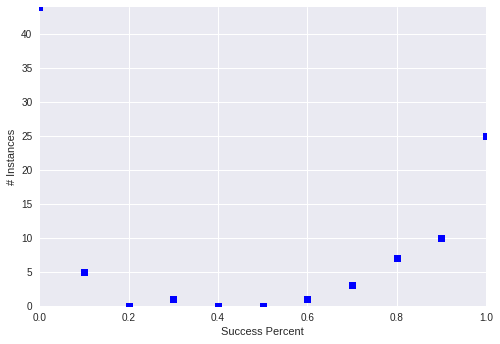

In [0]:
succ_percent = [i / float(MAX_ROUNDS) for i in matrix_of_metrics[0]]
percents = [i / float(MAX_ROUNDS) for i in range(0,MAX_ROUNDS+1)]
freq = []
for p in percents:
  freq.append(succ_percent.count(p))

import matplotlib.pyplot as plt
plt.plot(percents, freq, 'bs')
plt.axis([0, 1, min(freq), max(freq)])
plt.xlabel('Success Percent')
plt.ylabel('# Instances')
plt.show()



Τώρα σχετικά με τους καλύτερους συνδυασμούς παρατηρούμε τα εξής:


*   Όλες οι στρατηγικές eaSimple, M+L και M, L έδωσαν καλούς συνδυασμούς και πέτυχαν μάλιστα πλήρως τον στόχο
*   Οι στρατηγικές M,L χρειάζονται όπως και είναι λογικό περισσότερο χρόνο και evaluations ο οποίος συμπίπτει με το lambda factor. Δηλαδή θέσαμε lambda = 3/2 * POPSIZE και τα evals είναι μιάμιση φορά μεγαλύτερα από τη στρατηγική eaSimple.
*   Για την επιλογή του Crossover ο operator cxBlend απέδωσε ισοπεδωτικά καλύτερα από τον cxUniform και η πιο κατάλληλη υπερ παράμετρος ήταν η High.
*   Για την επιλογή του Mutation ο operator ShuffleIndexes υπερτερεί του Gaussian και η τιμή της υπερ παραμέτρου δεν έπαιξε τόσο ρόλο, δηλαδή δίνει καλά αποτελέσματα και για Low και για High.
*   Τέλος για την υπερ παράμετρο του selTournament operator η Low επικράτησε οριακά της High.



** Θεωρώντας ως δεύτερο βασικό κριτήριο το s.avg.evals δηλαδή ουσιαστικά το πόσο γρήγορα συγκλίνει ο αλγόριθμος κατά μέσο όρο έχουμε τους δυο καλύτερους συνδυασμούς που φαίνονται στον παρακάτω πίνακα. **






In [0]:
print(tabulate(final_df.head(2), headers='keys', tablefmt='psql', showindex="never"))

+---------------------------------+-------------+-----------------------+---------------+-------------+-------------+---------------+--------------+-------------+-------------+------------+
| Strategy                        | Crossover   | Mutation              | Selection     |   Successes |   s.avg.min |   s.avg.evals |   s.avg.gens |   avg.evals |     avg.min |   avg.time |
|---------------------------------+-------------+-----------------------+---------------+-------------+-------------+---------------+--------------+-------------+-------------+------------|
| eaMuPlusLambda 80 120 0.8 0.05  | cxBlendHigh | mutShuffleIndexesHigh | SelectionHigh |          10 | 1.65433e-05 |         735.2 |          7.4 |      5077.1 | 0           |   0.45701  |
| eaMuCommaLambda 80 120 0.8 0.05 | cxBlendHigh | mutGaussianLow        | SelectionLow  |          10 | 2.70281e-05 |         937.3 |          9.3 |      5088.3 | 1.78036e-28 |   0.401678 |
+---------------------------------+-------------+-

Για την τελική βελτιστοποίηση λοιπόν θα κρατήσουμε τον συνδυασμό:



*   eaMuPlusLambda
*   cxBlendHigh
*   mutShuffleIndexesHigh
*   SelectionHigh



### Τελική βελτιστοποίηση

#### Βελτιστοποίηση πιθανοτήτων διασταύρωσης και μετάλλαξης

Για τον καλύτερο συνδυασμό τελεστών-στρατηγικής (eaMuPlusLambda, cxBlendHigh, mutShuffleIndexesHigh, SelectionHigh) και σταθερό αριθμό γύρων MAX_ROUNDS = 15, πληθυσμού POPSIZE = 50 και γενεών MAX_GENS = 60, θα κάνουμε grid search στις πιθανότητες των τελεστών διασταύρωσης CXPB και μετάλλαξης MUTPB στο διάστημα [0.05 0.9] ώστε να βρoύμε το βέλτιστο συνδυασμό τους. 

(Μειώνουμε το population και τα gens για να κάνουμε γρηγορότερη αναζήτηση)

Επειδή θα δοκιμάσουμε σταδιακά πιο μικρά διαστήματα περιοχών τιμών θα ορίσουμε μια συνάρτηση την οποία θα επαναχρησιμοποιήσουμε στις περιοχές που πήραμε καλά αποτελέσματα για να πετύχουμε πιο γρήγορα καλή ακρίβεια.

Αρχικοποιούμε τα ορίσματά μας ώστε να χρησιμοποιήσουμε της συνάρτηση metrics_of_a_combination για τον συνδυασμό τελεστών-στρατηγικής που μας ενδιαφέρει.

In [0]:
def grid_search(fun_obj, CX_LIMITS, MUT_LIMITS, MAX_ROUNDS, combo, POPSIZE, MAX_GENS):
  
  #Σε αυτές τησ μεταβλητές θα κρατήσουμε τον καλύτερο συνδυασμό
  best_sum_success = -1
  best_avg_min_first_val = 1000000
  best_avg_min_evals = 1000000
  best_avg_min_first_gen = 1000000
  best_avg_tot_evals = 1000000
  best_avg_min_val = 1000000
  best_avg_time_of_round = 1000000
  
  best_cxpb = -1
  best_mutpb = -1
   
  for cxpb in np.linspace(*CX_LIMITS):

    for mutpb in np.linspace(*MUT_LIMITS):

      if (cxpb + mutpb <= 1):
        
        # Αρχικοποιούμε όλες τις μετρικές για έναν συνδυασμό cxpb και mutpb
        sum_min_val = 0
        sum_tot_evals = 0
        sum_time_of_round = 0
        sum_success = 0
        sum_min_first_gen = 0
        sum_min_first_val = 0
        sum_min_evals = 0    
        
        for r in range(0, MAX_ROUNDS, 1):
          
          r0, r1, r2, r3, r4, r5, r6 = metrics_of_a_combination(fun_obj, combo[0], combo[1], combo[2], combo[3], combo[4], combo[5], POPSIZE, MAX_GENS, cxpb, mutpb)
          
          sum_min_val += r0
          sum_tot_evals += r2
          sum_time_of_round += r6
          sum_success += r1
          sum_min_first_gen += r3
          sum_min_first_val += r4
          sum_min_evals += r5
          
        #print 'cxpb: ' + str(cxpb) + ', mutpb: ' + str(mutpb) + ' best succ :' + str(best_sum_success) + ' succ: ' + str(sum_success)
        
        avg_min_val =       sum_min_val/float(MAX_ROUNDS)
        avg_tot_evals =     sum_tot_evals/float(MAX_ROUNDS)
        avg_time_of_round = sum_time_of_round/float(MAX_ROUNDS)

        if (sum_success == 0):
          avg_min_first_gen = None
          avg_min_first_val = None
          avg_min_evals = None
        else:
          avg_min_first_gen = sum_min_first_gen/float(sum_success)
          avg_min_first_val = sum_min_first_val/float(sum_success)
          avg_min_evals    = sum_min_evals/float(sum_success)
          
          
        if (sum_success >= best_sum_success):
          
          #print 'ok1'
          if (avg_min_val <= best_avg_min_val or sum_success > best_sum_success ):
            if (avg_min_evals < best_avg_min_evals or sum_success > best_sum_success or avg_min_val < best_avg_min_val):
              
              #print 'ok2'
              best_sum_success = sum_success
              best_avg_min_first_val = avg_min_first_val
              best_avg_min_evals = avg_min_evals
              best_avg_min_first_gen = avg_min_first_gen
              best_avg_tot_evals = avg_tot_evals
              best_avg_min_val = avg_min_val
              best_avg_time_of_round = avg_time_of_round

              best_cxpb = cxpb
              best_mutpb = mutpb
          
  return best_sum_success, best_avg_min_first_val, best_avg_min_evals, best_avg_min_first_gen, best_avg_tot_evals, best_avg_min_val, best_avg_time_of_round, best_cxpb, best_mutpb
  

In [0]:
POPSIZE = 80
MAX_GENS = 60

MAX_ROUNDS = 10

goal = 0
delta = 0.00005
target = goal + delta


fun_obj = []
fun_obj.append(evalSchwefelFun) 
fun_obj.append([0,10]) 
fun_obj.append(2)
fun_obj.append(feasibleSchwefelFun) 
fun_obj.append(distanceSchwefelFun) 
fun_obj.append(100) 
fun_obj.append(target) 


combo = [1,1,0.45,0.3,15,1]

**Ξεκινάμε λοιπόν με αρχικό διάστημα το (0.05, 0.9) χωρίζοντας σε 5 διαστήματα  και στη συνέχεια μικραίνουμε τα διαστήματα βάσει των τιμών CXPB και ΜUTPB που βρίσκουμε**

In [0]:
CX_LIMITS = (0.05, 0.9, 5)
MUT_LIMITS = (0.05, 0.9, 5)

for i in range (0,4,1):
  
  print 'Searching CXPB in [ ' + str(CX_LIMITS[0]) + ', ' + str(CX_LIMITS[1]) + ' ] Interval ...'
  print 'Searching MUTPB in [ ' + str(MUT_LIMITS[0]) + ', ' + str(MUT_LIMITS[1]) + ' ] Interval ...'
  gs = grid_search(fun_obj, CX_LIMITS, MUT_LIMITS, MAX_ROUNDS, combo, POPSIZE, MAX_GENS)
  
  CXPB = gs[7]
  MUTPB = gs[8]
  
  print '\n'
  print 'Best CXPB : ' + str(CXPB) + ', Best MUTPB : ' + str(MUTPB)
  print '\n'
  print 'Successes : ' + str(gs[0])
  print 's.avg.min : ' + str(gs[1])
  print 's.avg.evals : ' + str(gs[2])
  print 's.avg.gens : ' + str(gs[3])
  print 'avg.evals : ' + str(gs[4])
  print 'avg.min : ' + str(gs[5])
  print 'avg.time : ' + str(gs[6])
  print '\n----------------------------'
  
  CX_LIMITS = ((0.05 + CXPB)/2, (0.9 + CXPB)/2, 5)
  MUT_LIMITS = ((0.05 + MUTPB)/2, (0.9 + MUTPB)/2, 5)

Searching CXPB in [ 0.05, 0.9 ] Interval ...
Searching MUTPB in [ 0.05, 0.9 ] Interval ...


Best CXPB : 0.9, Best MUTPB : 0.05


Successes : 10
s.avg.min : 1.5853546452074527e-05
s.avg.evals : 674.6
s.avg.gens : 6.2
avg.evals : 6809.3
avg.min : 0.0
avg.time : 0.585954904556

----------------------------
Searching CXPB in [ 0.47500000000000003, 0.9 ] Interval ...
Searching MUTPB in [ 0.05, 0.47500000000000003 ] Interval ...


Best CXPB : 0.58125, Best MUTPB : 0.05


Successes : 10
s.avg.min : 2.1099086803832296e-05
s.avg.evals : 559.9
s.avg.gens : 7.4
avg.evals : 4537.7
avg.min : 0.0
avg.time : 0.437747001648

----------------------------
Searching CXPB in [ 0.31562500000000004, 0.7406250000000001 ] Interval ...
Searching MUTPB in [ 0.05, 0.47500000000000003 ] Interval ...


Best CXPB : 0.6343750000000001, Best MUTPB : 0.05


Successes : 10
s.avg.min : 2.0091570144091635e-05
s.avg.evals : 687.7
s.avg.gens : 8.4
avg.evals : 4927.5
avg.min : 0.0
avg.time : 0.452837514877

---------------

Παρατηρούμε ότι όλες οι αναζητήσεις έδωσαν πολύ καλά αποτελέσματα. Θα κρατήσουμε αυτά της τελευταίας αναζήτησης

#### Εύρεση βέλτιστης (ελάχιστης) τιμής της συνάρτησης με τον ΓΑ

In [0]:
POPSIZE = 200
MAX_GENS = 150

goal = 0
delta = 0.00005
target = goal + delta


fun_obj = []
fun_obj.append(evalSchwefelFun) 
fun_obj.append([0,10]) 
fun_obj.append(2)
fun_obj.append(feasibleSchwefelFun) 
fun_obj.append(distanceSchwefelFun) 
fun_obj.append(100) 
fun_obj.append(target) 


CXPB = 0.76
MUTPB = 0.05

best_value, _, evaluations, _, _, _, total_time  = metrics_of_a_combination(fun_obj, 1, 1, 0.45, 0.3, 15, 2, POPSIZE, MAX_GENS, CXPB, MUTPB)

print 'Bέλτιστη τιμή: ' + str(best_value)
print 'Συνολικός αριθμός αποτιμήσεων: ' + str(evaluations)
print 'Χρόνος εκτέλεσης: ' + str(total_time) + ' secs'

Bέλτιστη τιμή: 0.0
Συνολικός αριθμός αποτιμήσεων: 36439
Χρόνος εκτέλεσης: 3.24626612663 secs


## Μέρος 2. Μελέτη κλιμακούμενης συνάρτησης

#### Ορισμός Βασικών Συναρτήσεων

Για καλύτερη εποπτεία παραθέτουμε την scalable συνάρτηση

**172 : Xin-She Yang Function 4 (Scalable) **

$$f(x_{1}, x_{2}, ... , x_{n}) = \bigg(\sum_{i=1}^{n}\sin^2(x_{i}) - e^{-\sum_{i=1}^{n}x_{i}^2}\bigg)e^{-\sum_{i=1}^{n}\sin^2\sqrt{\mid x_{i} \mid}} $$


In [0]:
def evalXinSheFun(ind):
  sum1 = 0;
  sum2 = 0;
  sum3 = 0;
  for x in ind:
    sum1 += pow(sin(x),2)
    sum2 += pow(x,2)
    sum3 += pow(sin(sqrt(abs(x))),2)
  return ((sum1 - exp(-sum2))*exp(-sum3) ,)

### Για D=2

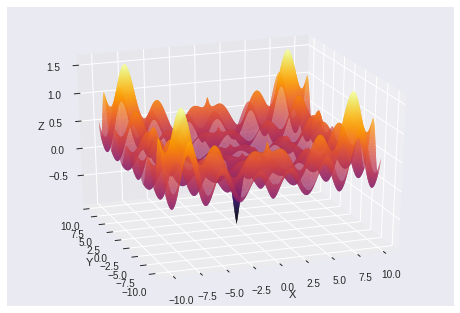

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(25, -110)
x = y = np.arange(-10.0, 10.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([evalXinSheFun([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Παρατηρούμε από το γράφημα ότι η συνάρτηση έχει πολλά τοπικά μέγιστα κι ελάχιστα. Το ολικό ελάχιστο είναι το -1 αλλά τα τοπικά ελάχιστα έχουν τιμή κοντά στο ολικό και βρίσκονται παντού στο χώρο του domain κάτι που θα δυσκολέψει αρκετά τον αλγόριθμο.

$$ x^{*} = (0,0,...,0), f(x^{*}) = -1 $$

In [0]:
print evalXinSheFun([0]*2)
print evalXinSheFun([0]*5)
print evalXinSheFun([0]*10)

(-1.0,)
(-1.0,)
(-1.0,)


$$-10 \leq x_{i} \leq 10 $$

In [0]:
MIN_BOUND = -10
MAX_BOUND = 10

def feasibleXinSheFun( indiv ):
    return all(x >= MIN_BOUND and x <= MAX_BOUND for x in indiv)

def distanceXinSheFun( indiv ) :
    dist = 0.0
    for x in indiv :
        penalty = 0
        if ( x < MIN_BOUND) : 
          penalty = 0 - x
        if ( x > MAX_BOUND) : 
          penalty = x - 10
        dist = dist + penalty
    return dist

#### Βελτιστοποίηση των τελεστών στρατηγικών

Απλά θα χρησιμοποιήσουμε όλες τις ήδη ορισμένες συναρτήσεις του πρώτου μέρους της άσκησης

In [0]:
# Αρχικοποιούμε έναν creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Το αρνητικό πρόσημο σημαίνει την ελαχιστοποίηση της συνάρτησης και το ότι τα weights είναι ένας αριθμός σημαίνει ότι ελαχιστοποιούμε ένα κριτήριο μόνο.
creator.create("Individual", list, fitness=creator.FitnessMin)

In [0]:
cxUniformLow = 0.1
cxUniformHigh = 0.4
cxBlendLow = 0.15
cxBlendHigh = 0.45

mate_list = [[cxUniformLow,cxUniformHigh],[cxBlendLow,cxBlendHigh]]

mutGaussianLow = 0.08
mutGaussianHigh = 0.25
mutShuffleIndexesLow = 0.06
mutShuffleIndexesHigh = 0.3

mutate_list = [[mutGaussianLow,mutGaussianHigh],[mutShuffleIndexesLow,mutShuffleIndexesHigh]]

selectionLow = 4
selectionHigh = 15

select_hyperparams = [selectionLow, selectionHigh]


POPSIZE = 80
MAX_GENS = 50
CXPB = 0.8
MUTPB = 0.05

MAX_ROUNDS = 10

goal = -1
delta = 0.0005
target = goal + delta


fun_obj = []
fun_obj.append(evalXinSheFun) 
fun_obj.append([-10,10]) 
fun_obj.append(2)
fun_obj.append(feasibleXinSheFun) 
fun_obj.append(distanceXinSheFun) 
fun_obj.append(10) 
fun_obj.append(target)


matrix_of_metrics = get_metrics(MAX_ROUNDS, fun_obj, mate_list, mutate_list, select_hyperparams, POPSIZE, MAX_GENS, CXPB, MUTPB )


Round 1 Completed.
Round 2 Completed.
Round 3 Completed.
Round 4 Completed.
Round 5 Completed.
Round 6 Completed.
Round 7 Completed.
Round 8 Completed.
Round 9 Completed.
Round 10 Completed.


In [0]:
strategy_names = []
crossover = []
mutation = []
selection = []

for s in ['eaSimple ' + str(POPSIZE) + ' ' + str(CXPB) + ' ' + str(MUTPB) , 'eaMuPlusLambda ' + str(POPSIZE) + ' ' + str(3*POPSIZE/2) + ' ' + str(CXPB) + ' ' + str(MUTPB), 'eaMuCommaLambda ' + str(POPSIZE) + ' ' + str(3*POPSIZE/2) + ' ' + str(CXPB) + ' ' + str(MUTPB) ]:
  for cx in ['cxUniform', 'cxBlend']:
    for mut in ['mutGaussian', 'mutShuffleIndexes' ]:
      for cx_hp in ['Low', 'High']:
        for mut_hp in ['Low', 'High']:
          for sel_hp in ['Low', 'High']:
            strategy_names.append(s)
            crossover.append(cx + cx_hp)
            mutation.append(mut + mut_hp)
            selection.append('Selection' + sel_hp)
            

                                                                                                           
data = {'Strategy': strategy_names,'Crossover': crossover,'Mutation': mutation,'Selection': selection,'Successes': matrix_of_metrics[0],'s.avg.min': matrix_of_metrics[1],'s.avg.evals': matrix_of_metrics[2],'s.avg.gens': matrix_of_metrics[3],'avg.evals': matrix_of_metrics[4],'avg.min': matrix_of_metrics[5],'avg.time': matrix_of_metrics[6]}

df = pd.DataFrame(data)
columnsTitles = ['Strategy', 'Crossover', 'Mutation' , 'Selection', 'Successes', 's.avg.min','s.avg.evals' ,'s.avg.gens' , 'avg.evals', 'avg.min', 'avg.time']
df = df.reindex(columns=columnsTitles)
final_df = df.sort_values(by=['avg.min', 's.avg.evals'])
print(tabulate(final_df, headers='keys', tablefmt='psql', showindex="never"))


+---------------------------------+---------------+-----------------------+---------------+-------------+-------------+---------------+--------------+-------------+------------+------------+
| Strategy                        | Crossover     | Mutation              | Selection     |   Successes |   s.avg.min |   s.avg.evals |   s.avg.gens |   avg.evals |    avg.min |   avg.time |
|---------------------------------+---------------+-----------------------+---------------+-------------+-------------+---------------+--------------+-------------+------------+------------|
| eaMuCommaLambda 80 120 0.8 0.05 | cxBlendLow    | mutShuffleIndexesLow  | SelectionLow  |          10 |   -0.999768 |      1617.7   |     16       |      5079   | -1         |   0.419287 |
| eaMuPlusLambda 80 120 0.8 0.05  | cxBlendLow    | mutShuffleIndexesHigh | SelectionLow  |          10 |   -0.999674 |      1629.2   |     16.2     |      5074.8 | -1         |   0.413872 |
| eaMuPlusLambda 80 120 0.8 0.05  | cxBlendHi

#### Τελική αναζήτηση και σχολιασμός

Όσον αφορά το DELTA ακολουθήσαμε τις οδηγίες της εκφώνησης, δηλαδή, ξεκινώντας από τιμή 0.1 σταδιακά τη μειώναμε σε τάξη μεγέθους έως ότου οι καλύτεροι συνδυασμοί να έχουν ποσοστό επιτυχιών κοντά στη μονάδα και οι χειρότεροι στο μηδέν. Καταλήξαμε στην τιμή delta =  0.0005 η οποία καταφέρνει ικανοποιητικά να διαχωρίσει τους συνδυασμούς σε πολύ καλούς και πολύ κακούς αλλά όχι τόσο καλά όπως στο πρώτο μέρος της άσκησης.

Παρακάτω παρουσιάζουμε ένα γράφημα όπου φαίνεται το πλήθος των συνδυασμών συναρτήσει των ποσοστών επιτυχίας.

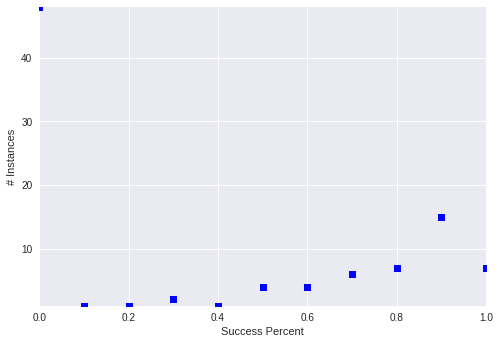

In [0]:
succ_percent = [i / float(MAX_ROUNDS) for i in matrix_of_metrics[0]]
percents = [i / float(MAX_ROUNDS) for i in range(0,MAX_ROUNDS+1)]
freq = []
for p in percents:
  freq.append(succ_percent.count(p))

import matplotlib.pyplot as plt
plt.plot(percents, freq, 'bs')
plt.axis([0, 1, min(freq), max(freq)])
plt.xlabel('Success Percent')
plt.ylabel('# Instances')
plt.show()

** Θεωρώντας ως δεύτερο βασικό κριτήριο το s.avg.evals δηλαδή ουσιαστικά το πόσο γρήγορα συγκλίνει ο αλγόριθμος κατά μέσο όρο έχουμε τους δυο καλύτερους συνδυασμούς που φαίνονται στον παρακάτω πίνακα. **

In [0]:
print(tabulate(final_df.head(2), headers='keys', tablefmt='psql', showindex="never"))

+---------------------------------+-------------+-----------------------+--------------+-------------+-------------+---------------+--------------+-------------+-----------+------------+
| Strategy                        | Crossover   | Mutation              | Selection    |   Successes |   s.avg.min |   s.avg.evals |   s.avg.gens |   avg.evals |   avg.min |   avg.time |
|---------------------------------+-------------+-----------------------+--------------+-------------+-------------+---------------+--------------+-------------+-----------+------------|
| eaMuCommaLambda 80 120 0.8 0.05 | cxBlendLow  | mutShuffleIndexesLow  | SelectionLow |          10 |   -0.999768 |        1617.7 |         16   |      5079   |        -1 |   0.419287 |
| eaMuPlusLambda 80 120 0.8 0.05  | cxBlendLow  | mutShuffleIndexesHigh | SelectionLow |          10 |   -0.999674 |        1629.2 |         16.2 |      5074.8 |        -1 |   0.413872 |
+---------------------------------+-------------+----------------

Για την τελική βελτιστοποίηση λοιπόν θα κρατήσουμε τον συνδυασμό:



*   eaMuCommaLambda
*   cxBlendLow
*   mutShuffleIndexesLow
*   SelectionLow

### Τελική βελτιστοποίηση

#### Βελτιστοποίηση πιθανοτήτων διασταύρωσης και μετάλλαξης

In [0]:
cxUniformLow = 0.1
cxUniformHigh = 0.4
cxBlendLow = 0.15
cxBlendHigh = 0.45
mutGaussianLow = 0.08
mutGaussianHigh = 0.25
mutShuffleIndexesLow = 0.06
mutShuffleIndexesHigh = 0.3
selectionLow = 4
selectionHigh = 15



POPSIZE = 80
MAX_GENS = 60

MAX_ROUNDS = 10

goal = -1
delta = 0.0005
target = goal + delta


fun_obj = []
fun_obj.append(evalXinSheFun) 
fun_obj.append([-10,10]) 
fun_obj.append(2)
fun_obj.append(feasibleXinSheFun) 
fun_obj.append(distanceXinSheFun) 
fun_obj.append(10) 
fun_obj.append(target)


combo = [1,1,cxBlendLow,mutShuffleIndexesLow,selectionLow,2]

**Ξεκινάμε λοιπόν με αρχικό διάστημα το (0.05, 0.9) χωρίζοντας σε 5 διαστήματα  και στη συνέχεια μικραίνουμε τα διαστήματα βάσει των τιμών CXPB και ΜUTPB που βρίσκουμε**

In [0]:
CX_LIMITS = (0.05, 0.9, 5)
MUT_LIMITS = (0.05, 0.9, 5)

for i in range (0,4,1):
  
  print 'Searching CXPB in [ ' + str(CX_LIMITS[0]) + ', ' + str(CX_LIMITS[1]) + ' ] Interval ...'
  print 'Searching MUTPB in [ ' + str(MUT_LIMITS[0]) + ', ' + str(MUT_LIMITS[1]) + ' ] Interval ...'
  gs = grid_search(fun_obj, CX_LIMITS, MUT_LIMITS, MAX_ROUNDS, combo, POPSIZE, MAX_GENS)
  
  CXPB = gs[7]
  MUTPB = gs[8]
  
  print '\n'
  print 'Best CXPB : ' + str(CXPB) + ', Best MUTPB : ' + str(MUTPB)
  print '\n'
  print 'Successes : ' + str(gs[0])
  print 's.avg.min : ' + str(gs[1])
  print 's.avg.evals : ' + str(gs[2])
  print 's.avg.gens : ' + str(gs[3])
  print 'avg.evals : ' + str(gs[4])
  print 'avg.min : ' + str(gs[5])
  print 'avg.time : ' + str(gs[6])
  print '\n----------------------------'
  
  CX_LIMITS = ((0.05 + CXPB)/2, (0.9 + CXPB)/2, 5)
  MUT_LIMITS = ((0.05 + MUTPB)/2, (0.9 + MUTPB)/2, 5)

Searching CXPB in [ 0.05, 0.9 ] Interval ...
Searching MUTPB in [ 0.05, 0.9 ] Interval ...


Best CXPB : 0.6875, Best MUTPB : 0.2625


Successes : 10
s.avg.min : -0.9996564564158387
s.avg.evals : 1785.6
s.avg.gens : 15.9
avg.evals : 6808.5
avg.min : -1.0
avg.time : 0.49499373436

----------------------------
Searching CXPB in [ 0.36875, 0.79375 ] Interval ...
Searching MUTPB in [ 0.15625, 0.58125 ] Interval ...


Best CXPB : 0.79375, Best MUTPB : 0.15625


Successes : 10
s.avg.min : -0.9997060041140419
s.avg.evals : 1695.7
s.avg.gens : 15.2
avg.evals : 6806.8
avg.min : -1.0
avg.time : 0.522004699707

----------------------------
Searching CXPB in [ 0.421875, 0.846875 ] Interval ...
Searching MUTPB in [ 0.103125, 0.528125 ] Interval ...


Best CXPB : 0.7406250000000001, Best MUTPB : 0.20937499999999998


Successes : 10
s.avg.min : -0.9996833147970516
s.avg.evals : 1620.5
s.avg.gens : 14.5
avg.evals : 6798.7
avg.min : -1.0
avg.time : 0.512982368469

----------------------------
Searching

#### Εύρεση βέλτιστης (ελάχιστης) τιμής της συνάρτησης με τον ΓΑ

In [0]:
POPSIZE = 200
MAX_GENS = 150

goal = -1
delta = 0.0005
target = goal + delta


fun_obj = []
fun_obj.append(evalXinSheFun) 
fun_obj.append([-10,10]) 
fun_obj.append(2)
fun_obj.append(feasibleXinSheFun) 
fun_obj.append(distanceXinSheFun) 
fun_obj.append(10) 
fun_obj.append(target)


CXPB = 0.75
MUTPB = 0.2

best_value, _, evaluations, _, _, _, total_time  = metrics_of_a_combination(fun_obj, 1, 1, 0.15, 0.06, 4, 1, POPSIZE, MAX_GENS, CXPB, MUTPB)

print 'Bέλτιστη τιμή: ' + str(best_value)
print 'Συνολικός αριθμός αποτιμήσεων: ' + str(evaluations)
print 'Χρόνος εκτέλεσης: ' + str(total_time) + ' secs'

Bέλτιστη τιμή: -1.0
Συνολικός αριθμός αποτιμήσεων: 42711
Χρόνος εκτέλεσης: 3.2449491024 secs



### Για D=1, 10, 20, 40 και μεγαλύτερες διαστάσεις

Για τον βέλτιστο αλγόριθμο (που βρήκατε για τις 2 διαστάσεις) και για διαφορετικές τιμές/τάξεις μεγέθους D=1, 10, 20, 40 ή και περισσότερων διαστάσεων του πεδίου ορισμού (σταθερά MAX_GENS και MAX_ROUNDS>=10) τυπώστε πίνακα με: **αριθμό διαστάσεων**, **αριθμό επιτυχιών**, **μέσο ολικό ελάχιστο**, **μέσο αριθμό αποτιμήσεων** και **μέσο χρόνο** (προφανώς βασιστείτε στην αρχική βοηθητική συνάρτηση εκτύπωσης αποτελεσμάτων). 

Σημειώστε ότι οποιεσδήποτε ποινές για άτομα εκτός ορισμού καθώς και τo DELTA, προκειμένου να είναι αποτελεσματικά ως προς την κλιμάκωση των διαστάσεων, θα πρέπει να οριστούν εμπειρικά μεν, αλλά οπωσδήποτε συναρτήσει του πλήθους των διαστάσεων (μεγαλύτερες ποινές για μεγαλύτερες διαστάσεις, για το DELTA έχουν δοθεί οδηγίες σε προηγούμενο section).

α) Σχολιάστε τα αποτελέσματα του πίνακα.

β) Ποιες πιστεύετε είναι οι αιτίες του φαινομένου;

γ) Για σταθερό αριθμό γενεών, πώς μπορούμε να βελτιώσουμε τα αποτελέσματα σε μεγάλες διαστάσεις ως προς το σκέλος της μέσης βέλτιστης τιμής; (Mπορεί να υπάρχουν περισσότερες προσεγγίσεις στο ίδιο πρόβλημα.)

**Σημείωση:** όπως συνήθως συμβαίνει στα υπολογιστικά προβλήματα, μεγαλύτερες διαστάσεις εισόδου σημαίνουν και μεγαλύτερους χρόνους εκτέλεσης. Ταυτόχρονα, οι προς μελέτη συναρτήσεις όλων των ομάδων έχουν διαφορετικές ιδιότητες και βαθμούς δυσκολίας. Συνεπώς, είναι αδύνατον να δώσουμε γενική οδηγία του τί είναι μεγάλες ή μεγαλύτερες διαστάσεις που να ισχύει για όλες τις συναρτήσεις. Δίνουμε κάποιες ενδεικτικές τιμές αλλά μπορείτε να τις προσαρμόσετε (και προς τα κάτω αλλά κυρίως προς τα πάνω) ανάλογα με τους διαθέσιμους πόρους, τον αριθμό επαναλήψεων και του τί θεωρείτε λογικά πλαίσια χρόνου αναμονής.

In [0]:
POPSIZE = 100
MAX_GENS = 12

goal = -1
delta = 0.005
target = goal + delta


fun_obj = []
fun_obj.append(evalXinSheFun) 
fun_obj.append([-10,10]) 
fun_obj.append(2)
fun_obj.append(feasibleXinSheFun) 
fun_obj.append(distanceXinSheFun) 
fun_obj.append(10) 
fun_obj.append(target)

CXPB = 0.75
MUTPB = 0.2



MAX_ROUNDS = 20


def metrics_of_dimensions(dimensions):


 
  num_of_successes = [0.0]*len(dimensions)
  avg_min_val = [0.0]*len(dimensions)
  avg_evals = [0.0]*len(dimensions)
  avg_time = [0.0]*len(dimensions)



  j = 0
  for dimension in dimensions:

    fun_obj[2] = dimension
    fun_obj[5] = 10*dimension # delta penalty  

    print 'Dimensions : ' + str(dimension)

    for r in range(0,MAX_ROUNDS,1):

      min_val, success, evaluations, _, _, _, total_time  = metrics_of_a_combination(fun_obj, 1, 1, 0.15, 0.06, 4, 1, POPSIZE, MAX_GENS, CXPB, MUTPB)

      num_of_successes[j] += success
      avg_min_val[j] += min_val
      avg_evals[j] += evaluations
      avg_time[j] += total_time
    
    num_of_successes[j] = num_of_successes[j]/MAX_ROUNDS
    avg_min_val[j] = avg_min_val[j]/MAX_ROUNDS
    avg_evals[j] = avg_evals[j]/MAX_ROUNDS
    avg_time[j] = avg_time[j]/MAX_ROUNDS
    j += 1


  data = {'Dimensions': dimensions, 'Successes %' : num_of_successes, 'avg.min': avg_min_val, 'avg.evals':avg_evals, 'avg.time': avg_time}

  df = pd.DataFrame(data)
  columnsTitles = ['Dimensions', 'Successes %', 'avg.min' , 'avg.evals', 'avg.time']
  df = df.reindex(columns=columnsTitles)
  final_df = df.sort_values(by=['Dimensions'])
  print(tabulate(final_df, headers='keys', tablefmt='psql', showindex="never"))
    
    
    
  
  
  
  

In [0]:
dimensions = [2,10,20,40] # Δεν μπορώ να έχω dimension 1 γιατί χρησιμοποιώ το mutShuffleIndexes που χρειάζεται τουλάχιστον δυο μεταβλητές

metrics_of_dimensions(dimensions)


Dimensions : 2
Dimensions : 10
Dimensions : 20
Dimensions : 40
+--------------+---------------+--------------+-------------+------------+
|   Dimensions |   Successes % |      avg.min |   avg.evals |   avg.time |
|--------------+---------------+--------------+-------------+------------|
|            2 |           0.9 | -0.996803    |     1663.75 |   0.127808 |
|           10 |           0   |  6.96038e-05 |     1669.15 |   0.192867 |
|           20 |           0   |  3.36686e-08 |     1667.75 |   0.286174 |
|           40 |           0   |  2.79329e-15 |     1666.95 |   0.424231 |
+--------------+---------------+--------------+-------------+------------+


Παρατηρούμε ότι μετά τις δύο διαστάσεις ο αλγόριθμος δεν βρίσκει ούτε μια φορά το **ολικό ελάχιστο -1**, αντ΄αυτού συγκλίνει στα **τοπικά ελάχιστα** της συνάρτησης που είναι το **μηδέν**. Αυτές αποτελούν τις αιτίες του φαινομένου καθώς ο αλγόριθμος θεωρεί ότι αποτελούν καλές λύσεις για να συνεχίσει στην αναζήτηση του ολικού ελαχίστου με αποτέλεσμα να κάνει κύκλους.

Μελετώντας το **benchmarking** της συνάρτησης **XinSheYang04** (http://infinity77.net/global_optimization/test_functions.html) βλέπουμε ότι για **N = 2** και **random points (population) = 100 ** το **Overall Success % = 26.33 ** που εκδηλώνει ένα μεγάλο **hardness** και άρα για τα επόμενα ερωτήματα που ακολουθούν θα χρησιμοποιηθούν "μικρές" διαστάσεις.

Για σταθερό αριθμό γενεών, πειραματιστήκαμε με τα CXPB, MUTPB και τις υπερπαραμέτρους αλλά καταλήξαμε στο ότι ο μόνος τρόπος με τον οποίο μπορούμε να βελτιώσουμε τα αποτελέσματα σε μεγάλες διαστάσεις ως προς το σκέλος της μέσης βέλτιστης τιμής είναι να αυξήσουμε το population με αποτέλεσμα να δώσουμε στον αλγόριθμο περισσότερα σημεία στο χώρο.

In [0]:
POPSIZE = 1000
MAX_GENS = 30

goal = -1
delta = 0.05
target = goal + delta


fun_obj = []
fun_obj.append(evalXinSheFun) 
fun_obj.append([-10,10]) 
fun_obj.append(2)
fun_obj.append(feasibleXinSheFun) 
fun_obj.append(distanceXinSheFun) 
fun_obj.append(10) 
fun_obj.append(target)

CXPB = 0.2
MUTPB = 0.8

MAX_ROUNDS = 10

In [0]:
dimensions = [2,3,4,5,6,7] # Δεν μπορώ να έχω dimension 1 γιατί χρησιμοποιώ το mutShuffleIndexes που χρειάζεται τουλάχιστον δυο μεταβλητές

metrics_of_dimensions(dimensions)

Dimensions : 2
Dimensions : 3
Dimensions : 4
Dimensions : 5
Dimensions : 6
Dimensions : 7
+--------------+---------------+--------------+-------------+------------+
|   Dimensions |   Successes % |      avg.min |   avg.evals |   avg.time |
|--------------+---------------+--------------+-------------+------------|
|            2 |           1   | -1           |       44500 |    2.78481 |
|            3 |           1   | -0.99996     |       44500 |    3.02547 |
|            4 |           0.1 | -0.0996254   |       44500 |    3.13733 |
|            5 |           0   | -0.0518411   |       44500 |    3.22053 |
|            6 |           0   |  9.3048e-06  |       44500 |    3.52238 |
|            7 |           0   |  6.91683e-06 |       44500 |    3.67405 |
+--------------+---------------+--------------+-------------+------------+


### Βελτιστοποίηση σε μεγάλες διαστάσεις

Επιλέγουμε ως διάσταση εισόδου την 3 και θα δείξουμε τη μεταβολή που έχει στις καλύτερες τιμές με διαφορετικό population size

In [0]:
for POPSIZE in range(100,1000,100):
  
  print 'POPULATION SIZE: ' + str(POPSIZE)
  metrics_of_dimensions([3])

POPULATION SIZE: 100
Dimensions : 3
+--------------+---------------+-----------+-------------+------------+
|   Dimensions |   Successes % |   avg.min |   avg.evals |   avg.time |
|--------------+---------------+-----------+-------------+------------|
|            3 |           0.2 | -0.198591 |        4450 |   0.262876 |
+--------------+---------------+-----------+-------------+------------+
POPULATION SIZE: 200
Dimensions : 3
+--------------+---------------+-----------+-------------+------------+
|   Dimensions |   Successes % |   avg.min |   avg.evals |   avg.time |
|--------------+---------------+-----------+-------------+------------|
|            3 |           0.3 | -0.484796 |        8900 |   0.523729 |
+--------------+---------------+-----------+-------------+------------+
POPULATION SIZE: 300
Dimensions : 3
+--------------+---------------+-----------+-------------+------------+
|   Dimensions |   Successes % |   avg.min |   avg.evals |   avg.time |
|--------------+------------

2. Βρείτε μια νέα -σταθερή- διάσταση, πιθανότατα μικρότερη από την προηγούμενη και ένα DELTA που να σας δίνουν 35% - 50% επιτυχίες. Μπορείτε να μειώσετε το DELTA στο μισό και να διπλασιάσετε το ποσοστό των επιτυχιών; Μπορείτε να ξαναμειώσετε στο μισό το DELTA και να αυξήσετε επιπρόσθετα το ποσοστό των επιτυχιών; Αν όχι, κατα πόσο κατ'ελάχιστον πρέπει να αυξήσετε τον αριθμό των γενεών για να πετύχετε σημαντική αύξηση των επιτυχιών;

Επιλέγουμε την τρίτη διάσταση με POPSIZE = 300 και delta = 0.0005

In [0]:
delta = 0.0005
POPSIZE = 300
MAX_GENS = 30
MAX_ROUNDS = 50 # Χρειάστηκε να αυξήσουμε τα MAX ROUNDS για να μην παίζουν τα αποτελέσματα σε κάθε εκτέλεση του block

metrics_of_dimensions([3])

Dimensions : 3
+--------------+---------------+-----------+-------------+------------+
|   Dimensions |   Successes % |   avg.min |   avg.evals |   avg.time |
|--------------+---------------+-----------+-------------+------------|
|            3 |          0.46 | -0.499179 |       13350 |   0.842304 |
+--------------+---------------+-----------+-------------+------------+


Μειώνουμε το delta στο μισό

In [0]:
delta = delta/2.0

metrics_of_dimensions([3])

Dimensions : 3
+--------------+---------------+-----------+-------------+------------+
|   Dimensions |   Successes % |   avg.min |   avg.evals |   avg.time |
|--------------+---------------+-----------+-------------+------------|
|            3 |          0.42 | -0.466059 |       13350 |   0.834015 |
+--------------+---------------+-----------+-------------+------------+


Αυξάνοντας σταδιακά στο παρακάτω block τα MAX_GENS το μέγιστο ποσοστό επιτυχιών που καταφέραμε ήταν 0.6 το οποίο στη συνέχεια παρέμενε ίδιο για MAX_GENS > 400

In [0]:
MAX_GENS = 400
metrics_of_dimensions([3])

Dimensions : 3
+--------------+---------------+-----------+-------------+------------+
|   Dimensions |   Successes % |   avg.min |   avg.evals |   avg.time |
|--------------+---------------+-----------+-------------+------------|
|            3 |           0.6 |  -0.61284 |      269850 |    16.6222 |
+--------------+---------------+-----------+-------------+------------+
